In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten,Dropout,BatchNormalization,Lambda
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPool1D,Embedding
from keras.layers import LSTM,GRU,RNN, CuDNNLSTM,CuDNNGRU
from keras.models import Sequential
from keras.optimizers import Adam, Adagrad,Adadelta,Nadam
from keras import callbacks
from keras import regularizers
from keras.utils import plot_model
from keras.models import load_model

from matplotlib import pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv("D:/INSOFE/Material/20190224_Batch52_CSE7321c_CUTe/train_data.csv",na_values= [""], encoding= "utf-8")
test = pd.read_csv("D:/INSOFE/Material/20190224_Batch52_CSE7321c_CUTe/test_data.csv",na_values= [""], encoding= "utf-8")

In [3]:
tf.__version__

'1.12.0'

In [4]:
k.__version__

'2.2.4'

In [5]:
train.head()

,categories,converse
0,QUERIES FROM PHARMACY,please to verify instructions for drugname pat...
1,NEW APPOINTMENT,lmovm for patients mother to and schd rov trac...
2,OTHERS,labtype and insurance approval other incoming ...
3,OTHERS,clinical list changes medfusion secure electro...
4,MEDICATION RELATED,wants to wean off medication work phone name d...


In [6]:
test.head()

,id,converse
0,1,request to speak with rn no given patients ref...
1,2,patients husband ret name spouse for other pat...
2,3,fyi in his szs mom other he has an appointment...
3,4,Rx refill drugname from pharmacy name reason f...
4,5,need more time for testing dad is requesting a...


In [7]:
print(train.shape)
print(test.shape)

(48699, 2)
(8581, 2)


In [8]:
print(train.dtypes)
print(test.dtypes)

categories    object
converse      object
dtype: object
id           int64
converse    object
dtype: object


### Preprocessing

In [10]:
train["categories"] = train["categories"].astype(str)
train["converse"] = train["converse"].astype(str)
test["converse"] = test["converse"].astype(str)

In [11]:
print(train.shape)
print(test.shape)

(48699, 2)
(8581, 2)


In [12]:
print("Max length: %s" %train.converse.str.len().max())
print("Mean length: %s" %train.converse.str.len().mean())
print("Min length: %s" %train.converse.str.len().min())

Max length: 2440
Mean length: 473.03648945563566
Min length: 3


In [15]:
MAX_SEQ_LEN = 450
VOCAB_SIZE = 20000

In [16]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE)
tokenizer.fit_on_texts(train["converse"])

train_sequences = tokenizer.texts_to_sequences(train["converse"])
test_sequences = tokenizer.texts_to_sequences(test["converse"])

In [17]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 35747 unique tokens.


In [18]:
train_data = pad_sequences(train_sequences, maxlen= MAX_SEQ_LEN)
test_data = pad_sequences(test_sequences, maxlen= MAX_SEQ_LEN)
print(train_data.shape)
print(test_data.shape)

(48699, 450)
(8581, 450)


In [19]:
print(len(np.unique(train_data)))

20000


In [20]:
train_labels = train['categories']

In [21]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)

print(label_encoder.classes_)

['CANCELLATION' 'CHANGE OF HOSPITAL' 'CHANGE OF PHARMACY'
 'CHANGE OF PROVIDER' 'FOLLOW UP ON PREVIOUS REQUEST' 'JUNK' 'LAB RESULTS'
 'MEDICATION RELATED' 'NEW APPOINTMENT' 'OTHERS' 'PRIOR AUTHORIZATION'
 'PROVIDER' 'QUERIES FROM INSURANCE FIRM' 'QUERIES FROM PHARMACY'
 'QUERY ON CURRENT APPOINTMENT' 'REFILL' 'RESCHEDULING'
 'RUNNING LATE TO APPOINTMENT'
 'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)'
 'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)' 'SYMPTOMS']


In [22]:
print(np.unique(train_labels, return_counts = True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]), array([ 564,  127,   47,  811,  304,   18, 2253, 9010, 8907, 6253, 1043,
       1677,   91, 1464,  559, 8347, 1383,  590, 3018, 1212, 1021],
      dtype=int64))


In [23]:
#convert to labels to one-hot-coded
train_tensor = to_categorical(np.array(train_labels))

print("Train tensor shape:",train_data.shape)
print("Train labels tensor shape:",train_tensor.shape)

Train tensor shape: (48699, 450)
Train labels tensor shape: (48699, 21)


### Building Convolutional Neural Network

In [24]:
EMBEDDING_DIM = 100
INITIALIZER = 'he_uniform'
REGULARIZER = regularizers.l2(0.01)

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim= VOCAB_SIZE, 
                    output_dim= EMBEDDING_DIM ,
                    input_length= MAX_SEQ_LEN,
                    embeddings_regularizer = REGULARIZER
                   ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 3,activation= 'relu',
                 kernel_initializer= INITIALIZER ,
                 #kernel_regularizer= REGULARIZER
                ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',
                 kernel_initializer= INITIALIZER,
                 #kernel_regularizer= REGULARIZER
                 ))
cnn_model.add(GlobalMaxPool1D())
#cnn_model.add(MaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(BatchNormalization())

#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))
#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))

cnn_model.add(Dense(128, activation= 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(21,activation= 'softmax'))

### Configure the model for training

In [25]:
adam = Adam(lr=0.001)
#adagrad = Adagrad()
#adadelta = Adadelta()
#nadam = Nadam(lr=0.001)
cnn_model.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy']
             )

cnn_model.summary()
metric = "val_acc"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 450, 100)          2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 448, 64)           19264     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 444, 64)           20544     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
__________

#### Define callbacks

In [28]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor= metric, factor= 0.1,
                                       patience= 10, min_lr= 0.00001,
                                       verbose= 1)

early_stop = callbacks.EarlyStopping(monitor= metric, mode= 'auto',
                                     patience= 15,
                                    verbose= 1)
                                    #restore_best_weights= True)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
file_path = "D:/INSOFE/Material/20190224_Batch52_CSE7321c_CUTe/cnn_weights.csv"
model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)

#### Fit the Model

In [29]:
history = cnn_model.fit(train_data , train_tensor ,
         batch_size = 64, shuffle = True,
         epochs=1000,validation_split = 0.2,
         callbacks = [reduce_lr,early_stop,model_chkpt]
         )

Train on 38959 samples, validate on 9740 samples
Epoch 1/1000
38959/38959 [==============================] - 115s 3ms/step - loss: 1.3641 - acc: 0.6819 - val_loss: 1.1819 - val_acc: 0.7118
Epoch 2/1000
38959/38959 [==============================] - 116s 3ms/step - loss: 1.2671 - acc: 0.6981 - val_loss: 1.1374 - val_acc: 0.7192
Epoch 3/1000
38959/38959 [==============================] - 117s 3ms/step - loss: 1.2193 - acc: 0.7073 - val_loss: 1.1076 - val_acc: 0.7252
Epoch 4/1000
38959/38959 [==============================] - 118s 3ms/step - loss: 1.2025 - acc: 0.7083 - val_loss: 1.1257 - val_acc: 0.7211
Epoch 5/1000
38959/38959 [==============================] - 119s 3ms/step - loss: 1.1835 - acc: 0.7121 - val_loss: 1.0983 - val_acc: 0.7220
Epoch 6/1000
38959/38959 [==============================] - 119s 3ms/step - loss: 1.1639 - acc: 0.7150 - val_loss: 1.0944 - val_acc: 0.7291
Epoch 7/1000
38959/38959 [==============================] - 118s 3ms/step - loss: 1.1452 - acc: 0.7199 - val_lo

#### Capture the model metrics

In [30]:
train_acc = history.history['acc']
train_loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

#### Plot the Model accuracies and losses

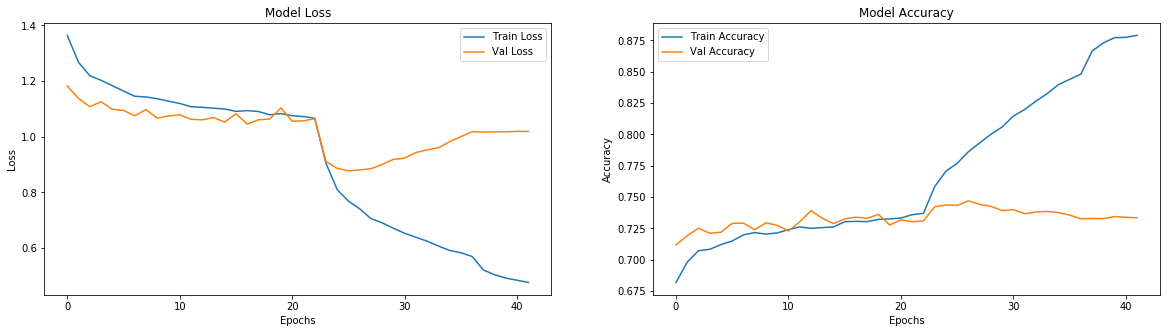

In [31]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,2,1)
ax.set_title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss , label ="Train Loss")
plt.plot(val_loss, label ="Val Loss")
plt.legend()

ax = plt.subplot(1,2,2)
ax.set_title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Val Accuracy")
plt.legend()
plt.show();

In [33]:
best_weights_cnn = load_model(file_path)
evaluation = best_weights_cnn.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

48699/48699 [==============================] - 35s 725us/step
Train Loss: 0.652126 Train Accuracy: 0.809401


In [34]:
test_preds = best_weights_cnn.predict_classes(test_data)
result1_df = pd.DataFrame({"id" : test["id"]})
result1_df["categories"] = label_encoder.classes_[test_preds]
#print(result1_df.shape)
#result1_df.head()
result1_df.to_csv("D:/INSOFE/Material/20190224_Batch52_CSE7321c_CUTe/cnn_testweights.csv", index=False)